In [1]:
import random
SEED = 2022
random.seed(SEED)

In [2]:
ml_path = './MovieLens/'
nf_path = './Netflix/'

In [3]:
import csv
def read_csv(path, encoding):
    with open(path, 'r', encoding=encoding) as f:
        c = csv.reader(f)
        header = next(c)
        for line in c:
            d = dict(zip(header, line))
            yield d

In [4]:
# idx -> name
ml_item_mapping = dict()
# name -> idx
ml_item_mapping_inv = dict()
ambiguous_titles = set()

In [5]:
ml_item_mapping_path = ml_path + 'movies.csv'

In [6]:
for datum in read_csv(ml_item_mapping_path, 'utf-8'):
    mvid = datum['movieId']
    title = datum['title']
    title_processed = title.split(sep='(')
    title_processed = "(".join(title_processed[0:-1]).strip()
    if title_processed in ml_item_mapping_inv:
        if ml_item_mapping_inv[title_processed] != mvid:
            ambiguous_titles.add(title_processed)
            continue
    ml_item_mapping[mvid] = title_processed
    ml_item_mapping_inv[title_processed] = mvid

In [7]:
nf_item_mapping = dict()
nf_item_mapping_inv = dict()

In [8]:
nf_item_mapping_path = nf_path + 'movie_titles.csv'

In [10]:
for datum in read_csv(nf_item_mapping_path, 'gbk'):
    mvid = datum['movieId']
    title = datum['title']
    if title in nf_item_mapping_inv:
        if nf_item_mapping_inv[title] != mvid:
            ambiguous_titles.add(title)
    nf_item_mapping[mvid] = title
    nf_item_mapping_inv[title] = mvid

In [11]:
nf_item_names = set(nf_item_mapping_inv.keys())

In [12]:
ml_item_names = set(ml_item_mapping_inv.keys())

In [13]:
common = nf_item_names.intersection(ml_item_names)

In [14]:
len(common)

6526

In [15]:
len(ambiguous_titles)

2709

In [16]:
nf_item_mapping

{'1': 'Dinosaur Planet',
 '2': 'Isle of Man TT 2004 Review',
 '3': 'Character',
 '4': "Paula Abdul's Get Up & Dance",
 '5': 'The Rise and Fall of ECW',
 '6': 'Sick',
 '7': '8 Man',
 '8': 'What the #$*! Do We Know!?',
 '9': "Class of Nuke 'Em High 2",
 '10': 'Fighter',
 '11': 'Full Frame: Documentary Shorts',
 '12': 'My Favorite Brunette',
 '13': 'Lord of the Rings: The Return of the King: Extended Edition: Bonus Material',
 '14': 'Nature: Antarctica',
 '15': 'Neil Diamond: Greatest Hits Live',
 '16': 'Screamers',
 '17': '7 Seconds',
 '18': 'Immortal Beloved',
 '19': "By Dawn's Early Light",
 '20': 'Seeta Aur Geeta',
 '21': 'Strange Relations',
 '22': 'Chump Change',
 '23': "Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo",
 '24': 'My Bloody Valentine',
 '25': 'Inspector Morse 31: Death Is Now My Neighbour',
 '26': 'Never Die Alone',
 '27': "Sesame Street: Elmo's World: The Street We Live On",
 '28': 'Lilo and Stitch',
 '29': 'Boycott',
 '30': "Something's Gotta Giv

In [17]:
from collections import defaultdict

In [18]:
nf_common_rating = defaultdict(float)

In [19]:
nf_rating_path_base = nf_path + 'combined_data_'

In [20]:
nf_mv_names = set()

In [21]:
for i in range(1, 5):
    nf_rating_path = nf_rating_path_base + str(i) + ".txt"
    mv_id = None
    mv_name = None
    with open(nf_rating_path, "r") as f:
        for line in f.readlines():
            if line:
                if ":" in line:
                    mv_id = line.split(":")[0].strip()
                    if mv_id not in nf_item_mapping:
                        mv_id = None
                        mv_name = None
                        continue
                    mv_name = nf_item_mapping[mv_id]
                else:
                    if mv_name is None or mv_name not in common:
                        continue
                    if mv_name in ambiguous_titles:
                        continue
                    nf_mv_names.add(mv_name)
                    line = line.split(",")
                    uid, rating = line[0].strip(), line[1].strip()
                    nf_common_rating[(uid, mv_id)] = float(rating)

In [22]:
ml_mv_names = set()

In [23]:
source_common_rating = defaultdict(float)
ml_rating_path = ml_path + 'ratings.csv'
for datum in read_csv(ml_rating_path, encoding="utf8"):
    uid = datum['userId']
    mvid = datum['movieId']
    rating = float(datum['rating'])
    if mvid not in ml_item_mapping:
        continue
    item_name = ml_item_mapping[mvid]
    if item_name not in common:
        continue
    ml_mv_names.add(item_name)
    source_common_rating[(uid, mvid)] = rating

In [24]:
common = common.intersection(ml_mv_names).intersection(nf_mv_names)

In [25]:
len(common)

5362

In [24]:
len(nf_common_rating)

55278378

In [25]:
nf_item_users = dict()
nf_user_items = dict()
for (user, movie) in nf_common_rating:
    movie_name = nf_item_mapping[movie]
    if movie_name not in common:
        continue
    if movie not in nf_item_users:
        nf_item_users[movie] = list()
    if user not in nf_user_items:
        nf_user_items[user] = list()
    nf_item_users[movie].append(user)
    nf_user_items[user].append(movie)

In [26]:
print(f"user num: {len(nf_user_items)}, item num: {len(nf_item_users)}")

user num: 478009, item num: 5362


In [27]:
print(f"user degree: {len(nf_common_rating) / len(nf_user_items)}, item degree: {len(nf_common_rating) / len(nf_item_users)}")

user degree: 115.64296488141437, item degree: 10309.283476314808


In [28]:
user_degree_dist = defaultdict(int)
for k, v in nf_user_items.items():
    d = len(v)
    user_degree_dist[d] += 1

In [29]:
user_degree_dist_list = list(user_degree_dist.items())
user_degree_dist_list.sort()

In [30]:
deg, nums = list(zip(*user_degree_dist_list))

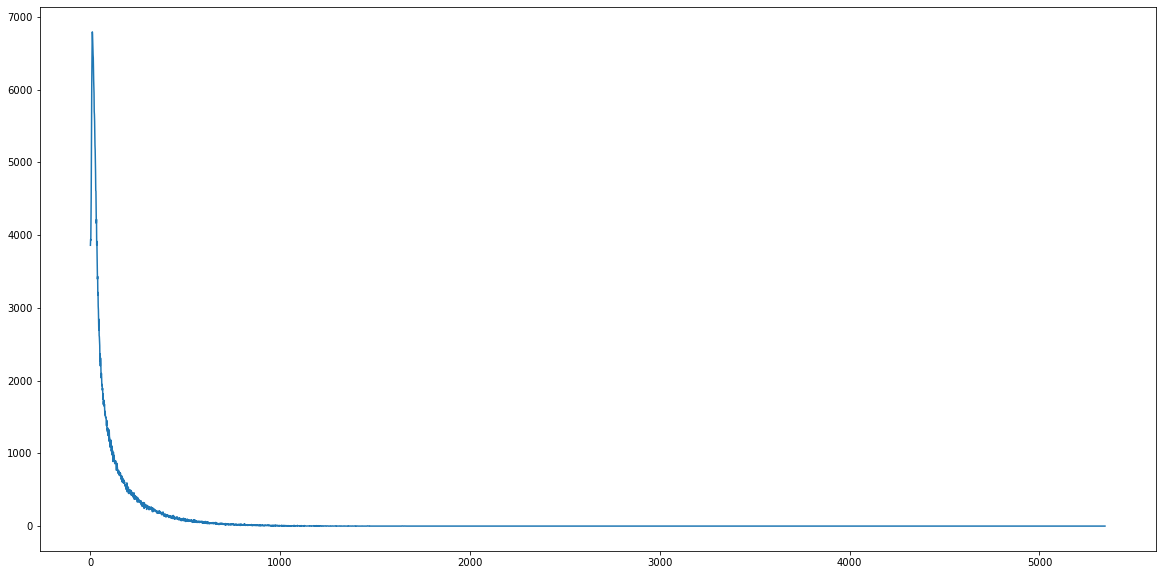

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(deg, nums)
plt.show()

In [32]:
user_degree_dist_list

[(1, 3861),
 (2, 3941),
 (3, 3930),
 (4, 4192),
 (5, 4509),
 (6, 5082),
 (7, 5595),
 (8, 6069),
 (9, 6422),
 (10, 6650),
 (11, 6794),
 (12, 6755),
 (13, 6648),
 (14, 6552),
 (15, 6479),
 (16, 6435),
 (17, 6240),
 (18, 6134),
 (19, 6022),
 (20, 5949),
 (21, 5700),
 (22, 5657),
 (23, 5563),
 (24, 5338),
 (25, 5235),
 (26, 5171),
 (27, 5028),
 (28, 4861),
 (29, 4613),
 (30, 4605),
 (31, 4415),
 (32, 4163),
 (33, 4217),
 (34, 3863),
 (35, 3914),
 (36, 3740),
 (37, 3613),
 (38, 3396),
 (39, 3433),
 (40, 3178),
 (41, 3212),
 (42, 3023),
 (43, 2973),
 (44, 2789),
 (45, 2697),
 (46, 2844),
 (47, 2619),
 (48, 2603),
 (49, 2547),
 (50, 2482),
 (51, 2271),
 (52, 2371),
 (53, 2203),
 (54, 2313),
 (55, 2301),
 (56, 2232),
 (57, 2040),
 (58, 2063),
 (59, 2099),
 (60, 2044),
 (61, 1931),
 (62, 1949),
 (63, 1899),
 (64, 1869),
 (65, 1897),
 (66, 1806),
 (67, 1743),
 (68, 1817),
 (69, 1673),
 (70, 1716),
 (71, 1717),
 (72, 1732),
 (73, 1662),
 (74, 1648),
 (75, 1675),
 (76, 1616),
 (77, 1528),
 (78, 15

In [33]:
selected_user_items = dict()
for k, v in nf_user_items.items():
    if len(v) >= 6 and len(v) <= 10:
        selected_user_items[k] = v.copy()

In [34]:
selected_item_users = dict()
for k, v in selected_user_items.items():
    for item in v:
        if item not in selected_item_users:
            selected_item_users[item] = list()
        selected_item_users[item].append(k)

In [35]:
selected_item_users_list = list(selected_item_users.items())

In [36]:
# selected_item_users_list.sort(key=lambda x: len(x[1]))

In [37]:
# selected_item_users_list = selected_item_users_list[:3800]

In [38]:
# selected_item_users = dict()
# selected_user_items = dict()
# for item, users in selected_item_users_list:
#     if item not in selected_item_users:
#         selected_item_users[item] = list()
#     for user in users:
#         if user not in selected_user_items:
#             selected_user_items[user] = list()
#         selected_item_users[item].append(user)
#         selected_user_items[user].append(item)

In [39]:
len(selected_user_items)

29818

In [40]:
len(selected_item_users)

4799

In [41]:
item_degree_dist = {k: len(v) for k, v in selected_item_users.items()}

In [50]:
item_degree_dist

{'10': 1,
 '5695': 336,
 '6122': 53,
 '10114': 259,
 '11647': 301,
 '11911': 204,
 '12523': 6,
 '17008': 151,
 '12': 1,
 '241': 165,
 '2590': 5,
 '2874': 569,
 '4067': 6,
 '5415': 6,
 '7634': 1,
 '10273': 5,
 '11100': 3,
 '15814': 17,
 '1972': 17,
 '2043': 17,
 '2360': 95,
 '2994': 1,
 '3817': 33,
 '5050': 82,
 '8743': 436,
 '15300': 11,
 '16474': 1,
 '1778': 1,
 '3245': 1,
 '5385': 8,
 '10979': 4,
 '12927': 1,
 '13546': 16,
 '16260': 15,
 '17': 66,
 '4914': 317,
 '7055': 56,
 '9939': 844,
 '12409': 38,
 '17506': 351,
 '11350': 13,
 '15646': 836,
 '16412': 41,
 '16640': 824,
 '1060': 83,
 '1499': 18,
 '6850': 156,
 '11040': 858,
 '16047': 300,
 '1962': 875,
 '3934': 6,
 '12338': 759,
 '14454': 915,
 '14940': 580,
 '16113': 643,
 '17324': 1281,
 '758': 759,
 '2705': 16,
 '8046': 21,
 '9756': 1289,
 '11588': 1,
 '13720': 1,
 '14154': 16,
 '15844': 499,
 '17152': 10,
 '290': 405,
 '5345': 819,
 '7635': 943,
 '16984': 440,
 '1324': 38,
 '3340': 1,
 '5327': 598,
 '6788': 2,
 '11077': 1067,


In [42]:
# item_degree_list = list(item_degree_dist.items())

In [43]:
# item_degree_list.sort(key=lambda x: x[1])

In [44]:
# item_degree_hist = dict()
# for _, i in item_degree_list:
#     if i not in item_degree_hist:
#         item_degree_hist[i] = 0
#     item_degree_hist[i] += 1

In [45]:
# sorted(item_degree_hist.items())

In [46]:
# item_degree_list_dist = dict()
# for _, d in item_degree_list:
#     if d not in item_degree_list_dist:
#         item_degree_list_dist[d] = 0
#     item_degree_list_dist[d] += 1

In [57]:
train_target_data = list()
test_target_data = list()
for user, items in selected_user_items.items():
    num = len(items)
    
#     test_idx = random.randint(0, num)
    items_copy = [(idx, item) for (idx, item) in enumerate(items)]
    items_copy.sort(key=lambda x: abs(item_degree_dist[x[1]] - 2))
    test_idx = items_copy[0][0]
    test_name = items_copy[0][1]
    if item_degree_dist[test_name] >= 2:
        item_degree_dist[test_name] -= 1
    else:
        test_idx = None
    for i in range(num):
        item = items[i]
        rating = nf_common_rating[(user, item)]
        if i == test_idx:
            test_target_data.append([user, item, rating])
        else:
            train_target_data.append([user, item, rating])

In [54]:
# train_target_data

In [58]:
test_target_data

[['1966514', '12409', 2.0],
 ['776794', '11350', 3.0],
 ['1328716', '1499', 5.0],
 ['455645', '17', 3.0],
 ['1748268', '17', 2.0],
 ['1403661', '17', 5.0],
 ['110622', '14475', 4.0],
 ['594161', '15531', 4.0],
 ['2043607', '17', 2.0],
 ['1762403', '17', 2.0],
 ['1733839', '13548', 2.0],
 ['498988', '17', 3.0],
 ['1314367', '17', 3.0],
 ['127215', '1768', 4.0],
 ['646666', '17', 1.0],
 ['777212', '17', 3.0],
 ['1374020', '17', 2.0],
 ['924498', '15816', 5.0],
 ['1909798', '12409', 5.0],
 ['1876690', '17', 3.0],
 ['1215431', '12409', 5.0],
 ['1225490', '15474', 3.0],
 ['413175', '17', 3.0],
 ['2334695', '15815', 4.0],
 ['1407450', '17062', 1.0],
 ['1501962', '17', 2.0],
 ['2421926', '10119', 3.0],
 ['560237', '17', 3.0],
 ['1420255', '17723', 5.0],
 ['1344646', '17', 1.0],
 ['260163', '17', 2.0],
 ['1543465', '17', 2.0],
 ['1011077', '17', 2.0],
 ['767729', '17', 3.0],
 ['1054715', '108', 3.0],
 ['1659827', '17', 1.0],
 ['1709330', '17', 4.0],
 ['705870', '17', 2.0],
 ['1176143', '17', 2

In [59]:
# make sure the user item sets of the test data is the subset of those of the train data
train_users, train_items, _ = list(zip(*train_target_data))
train_users = set(train_users)
train_items = set(train_items)
test_users, test_items, _ = list(zip(*test_target_data))
test_users = set(test_users)
test_items = set(test_items)
test_users_common = test_users.intersection(train_users)
test_items_common = test_items.intersection(train_items)

In [60]:
test_target_data_processed = []
for user, item, rating in test_target_data:
    if user not in test_users_common:
        continue
    if item not in test_items_common:
        continue
    test_target_data_processed.append([user, item, rating])

In [61]:
len(train_users)

29818

In [62]:
len(train_items)

4799

In [63]:
len(train_target_data)

227355

In [ ]:
# 19334 / 3589

In [64]:
len(test_target_data_processed)

15152

In [65]:
train_target_data[0]

['1164435', '10', 3.0]

In [66]:
len(train_items)

4799

In [67]:
user_idx_mapping = dict()
item_name_idx_mapping = dict()
for (user, item, rating) in train_target_data:
    item_name = nf_item_mapping[item]
    if item_name not in item_name_idx_mapping:
        item_name_idx_mapping[item_name] = len(item_name_idx_mapping)
    if user not in user_idx_mapping:
        user_idx_mapping[user] = len(train_items) + len(user_idx_mapping)

In [68]:
train_target_data_reindex = [[user_idx_mapping[u], item_name_idx_mapping[nf_item_mapping[i]], r] for u, i, r in train_target_data]

In [69]:
train_items_list = list(train_items)

In [70]:
# add negative instance for test
test_target_data_full = []
for user, item, rating in test_target_data_processed:
    test_target_data_full.append([user, item, rating])
    neg = random.sample(train_items_list, k=1)[0]
    for i in range(10):
        if (user, neg) not in nf_common_rating:
            break
        neg = random.sample(train_items_list, k=1)[0]
    if (user, neg) in nf_common_rating:
        continue
    test_target_data_full.append([user, neg, 0.])

In [71]:
test_target_data_full_reindex = [[user_idx_mapping[u], item_name_idx_mapping[nf_item_mapping[i]], r] for u, i, r in test_target_data_full]

In [72]:
len(test_target_data_full_reindex)

30304

In [73]:
test_target_data_reindex = [[user_idx_mapping[u], item_name_idx_mapping[nf_item_mapping[i]], r] for u, i, r in test_target_data_processed]

In [74]:
len(test_target_data_reindex)

15152

In [75]:
len(item_name_idx_mapping)

4799

In [76]:
def save_data(data, path):
    import pandas as pd
    df = pd.DataFrame(data)
    df.columns = ['user', 'item', 'rating']
    df.to_csv(path, index=False)

In [77]:
save_data(train_target_data_reindex, 'data_target.csv')

In [78]:
save_data(test_target_data_reindex, 'data_test.csv')

In [ ]:
# construct source domain data

In [79]:
len(item_name_idx_mapping)

4799

In [80]:
len(source_common_rating)

13609955

In [81]:
ml_item_users = dict()
ml_user_items = dict()
for (user, movie) in source_common_rating:
    movie_name = ml_item_mapping[movie]
    if movie_name not in item_name_idx_mapping:
        continue
    if movie not in ml_item_users:
        ml_item_users[movie] = list()
    if user not in ml_user_items:
        ml_user_items[user] = list()
    ml_item_users[movie].append(user)
    ml_user_items[user].append(movie)

In [82]:
print(f"user num: {len(ml_user_items)}, item num: {len(ml_item_users)}")

user num: 274101, item num: 4799


In [83]:
user_degree_dist = defaultdict(int)
for k, v in ml_user_items.items():
    d = len(v)
    user_degree_dist[d] += 1

In [84]:
user_degree_dist_list = list(user_degree_dist.items())
user_degree_dist_list.sort()

In [85]:
target = 600000

In [86]:
curr = 0
for deg, num in user_degree_dist_list:
    if deg < 8:
        continue
    curr += deg * num
    if curr >= target:
        print(deg)
        break

14


In [125]:
selected_user_set = set()
num = 0
target_deg = 12
for item, users in ml_item_users.items():
    users.sort(key=lambda x: abs(len(ml_user_items[x]) - target_deg))
    select_num = min(len(users), target_deg - 7)
    for i in range(select_num):
        selected_user_set.add(users[i])

In [126]:
len(selected_user_set)

12481

In [127]:
source_user_items = dict()
for k, v in ml_user_items.items():
    if k in selected_user_set:
        source_user_items[k] = v

In [128]:
sum([len(v) for _, v in source_user_items.items()])

737822

In [129]:
len(source_user_items)

12481

In [130]:
source_item_users = dict()
for k, v in source_user_items.items():
    for item in v:
        if item not in source_item_users:
            source_item_users[item] = list()
        source_item_users[item].append(k)

In [131]:
len(source_item_users)

4799

In [132]:
source_data = []

In [133]:
user_idx_mapping_source = dict()
for user, items in source_user_items.items():
    if user not in user_idx_mapping_source:
        user_idx_mapping_source[user] = len(user_idx_mapping_source) + len(user_idx_mapping)
    uid = user_idx_mapping_source[user]
    for item in items:
        mv_name = ml_item_mapping[item]
        rating = source_common_rating[(user, item)]
        mvid = item_name_idx_mapping[mv_name]
        source_data.append([uid, mvid, rating])

In [134]:
len(source_data)

737822

In [ ]:
767582 / 3589

In [ ]:
767582 / 18305 

In [135]:
save_data(source_data, 'data_source.csv')